## Importing required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Defining required classes
### Data class

In [2]:
class Data:
    def __init__(self, train_feature_file, train_target_file, test_file, cat_cols, num_cols, target_col, id_col):
        '''create train and test dataframe'''
        #create new copies instead of references
        self.cat_cols = list(cat_cols)
        self.num_cols = list(num_cols)
        self.feature_cols = cat_cols + num_cols
        self.target_col = target_col
        self.id_col = id_col
        self.label_encoders = {}
        self.train_df = self._create_train_df(train_feature_file, train_target_file)
        self.test_df = self._create_test_df(test_file)
    
    def label_encode_df(self, df, cols):
        '''creates one label encoder for each column in the data object instance'''
        for col in cols:
            if col in self.label_encoders:
                #if label encoder already exits for col, use it
                self._label_encode(df, col, self.label_encoders[col])
            else:
                self._label_encode(df, col)
    
    def inverse_encode_df(self, df, cols):
        '''does inverse label encoding'''
        for col in cols:
            if col in self.label_encoders:
                self._inverse_label_encode(df, col)  
            else:
                raise ValueError("label_encoders must be define for each col before calling inverse_encode_df")

    def _label_encode(self, df, col, le=None):
        '''label encodes data'''
        if le:
            df[col] = le.transform(df[col])
        else:
            le = LabelEncoder()
            le.fit(df[col])
            df[col] = le.transform(df[col])
            self.label_encoders[col] = le
        
    def _inverse_label_encode(self, df, col):
        '''inverse label encodes data'''
        le = self.label_encoders[col]
        df[col] = le.inverse_transform(df[col])
 
    def _create_train_df(self, train_feature_df, train_target_df, preprocess=True, label_encode=True):
        '''loads and merges training data features and targets, preprocesses data, encodes data'''
        train_feature_df = self._load_data(train_feature_file)
        train_target_df = self._load_data(train_target_file)
        train_df = self._merge_dfs(train_feature_df, train_target_df)
        if preprocess:
            train_df = self._clean_data(train_df)
            train_df = self._shuffle_data(train_df)
        if label_encode:
            self.label_encode_df(train_df, self.cat_cols)
        return train_df
    
    def _create_test_df(self, test_file, label_encode=True):
        '''loads and label encodes test data'''
        test_df = self._load_data(test_file)
        if label_encode:
            self.label_encode_df(test_df, self.cat_cols)
        return test_df
        
    def _load_data(self, file):
        return pd.read_csv(file)
    
    def _merge_dfs(self, df1, df2, key=None, left_index=False, right_index=False):
        return pd.merge(left=df1, right=df2, how='inner', on=key, left_index=left_index, right_index=right_index)
    
    def _clean_data(self, df):
        '''remove rows that contain salary <= 0 or duplicate job IDs'''
        df = df.drop_duplicates(subset='jobId')
        df = df[df.salary>0]
        return df
    
    def _shuffle_data(self, df):
         return shuffle(df).reset_index()

### FeatureGenerator class

In [3]:
class FeatureGenerator:
    def __init__(self, data):
        '''initializes class and creates groupby object for data'''
        self.data = data
        #able to generate features for new companies, but less accurate
        #self.cat_cols = ['jobType', 'degree', 'major', 'industry']
        self.cat_cols = data.cat_cols
        self.groups = data.train_df.groupby(self.cat_cols)
        
    def add_group_stats(self):
        '''adds group statistics to data stored in data object'''
        #get group stats
        group_stats_df = self._get_group_stats()
        group_stats_df.reset_index(inplace=True)
  
        #merge derived columns to original df
        self.data.train_df = self._merge_new_cols(self.data.train_df, group_stats_df, self.cat_cols, fillna=True)
        self.data.test_df = self._merge_new_cols(self.data.test_df, group_stats_df, self.cat_cols, fillna=True)      
        
        #update column lists
        group_stats_cols = ['group_mean', 'group_max', 'group_min', 'group_std', 'group_median']
        self._extend_col_lists(self.data, cat_cols=group_stats_cols)  
        
    def _get_group_stats(self):
        '''calculates group statistics'''
        target_col = self.data.target_col
        group_stats_df = pd.DataFrame({'group_mean': self.groups[target_col].mean()})
        group_stats_df['group_max'] = self.groups[target_col].max()
        group_stats_df['group_min'] = self.groups[target_col].min()
        group_stats_df['group_std'] = self.groups[target_col].std()
        group_stats_df['group_median'] = self.groups[target_col].median()
        return group_stats_df
        
    def _merge_new_cols(self, df, new_cols_df, keys, fillna=False):
        '''merges engineered features with original df'''
        df = pd.merge(df, new_cols_df, on=keys, how='left')
        if fillna:
            df.fillna(0, inplace=True)
        return df
        
    def _extend_col_lists(self, data, cat_cols=[], num_cols=[]):
        '''addes engineered feature cols to data col lists'''
        data.num_cols.extend(num_cols)
        data.cat_cols.extend(cat_cols)
        data.feature_cols.extend(num_cols + cat_cols)

### ModelContainer class

In [4]:
class ModelContainer:
    def __init__(self, models=[]):#, default_num_iters=10, verbose_lvl=0):
        '''initializes model list and dicts'''
        self.models = models
        self.best_model = None
        self.predictions = None
        self.mean_mse = {}
        #self.default_num_iters = default_num_iters
        #self.verbose_lvl = verbose_lvl
        
    def add_model(self, model):
        self.models.append(model)

    def cross_validate(self, data, k=3, num_procs=1):
        '''cross validate models using given data'''
        feature_df = data.train_df[data.feature_cols]
        target_df = data.train_df[data.target_col]
        for model in self.models:
            neg_mse = cross_val_score(model, feature_df, target_df, cv=k, n_jobs=num_procs, scoring='neg_mean_squared_error')
            self.mean_mse[model] = -1.0*np.mean(neg_mse)
    
    def select_best_model(self):
        '''select model with lowest mse'''
        self.best_model = min(self.mean_mse, key=self.mean_mse.get)
        
    def best_model_fit(self, features, targets):
        '''fits best model'''
        self.best_model.fit(features, targets)
    
    def best_model_predict(self, features):
        '''scores features using best model'''
        self.predictions = self.best_model.predict(features)
        
    def save_results(self):
        pass
    
    @staticmethod
    def get_feature_importance(model, cols):
        '''retrieves and sorts feature importances'''
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            feature_importances = pd.DataFrame({'feature':cols, 'importance':importances})
            feature_importances.sort_values(by='importance', ascending=False, inplace=True)
            #set index to 'feature'
            feature_importances.set_index('feature', inplace=True, drop=True)
            return feature_importances
        else:
            #some models don't have feature_importances_
            return "Feature importances do not exist for given model"

    def print_summary(self):
        '''prints summary of models, best model, and feature importance'''
        print('\nModel Summaries:\n')
        for model in models.mean_mse:
            print('\n', model, '- MSE:', models.mean_mse[model])
        print('\nBest Model:\n', models.best_model)
        print('\nMSE of Best Model\n', models.mean_mse[models.best_model])
        print('\nFeature Importances\n', models.get_feature_importance(models.best_model, data.feature_cols))

        feature_importances = self.get_feature_importance(models.best_model, data.feature_cols)
        feature_importances.plot.bar()
        plt.show()

## Defining parameters needed to create and run models

In [5]:
#define number of processors to use for parallel runs
num_procs = 4

#set verbose level for models
verbose_lvl = 0

#define input files
train_feature_file = 'data/train_features.csv'
train_target_file = 'data/train_salaries.csv'
test_file = 'data/test_features.csv'

#define variables
cat_cols = ['companyId', 'jobType', 'degree', 'major', 'industry']
num_cols = ['yearsExperience', 'milesFromMetropolis']
target_col = 'salary'
id_col = 'jobId'

#turn feature engineering on/off
engineer_features = True

### Creating Data object

In [7]:
data = Data(train_feature_file, train_target_file, test_file, cat_cols, num_cols, target_col, id_col)

## Engineering features
The purpose is to create and add some additional rows to the data frame. These rows tell the model some statistical data (mean, max, min and standard devisation) of the people of the same 'companyId', 'jobType', 'degree', 'major', and 'industry'.

In [8]:
if engineer_features:
    feature_generator = FeatureGenerator(data)
    feature_generator.add_group_stats()

## Creating model container and add models to it

In [9]:
#create model container
models = ModelContainer()

#create models -- hyperparameter tuning already done by hand for each model
models.add_model(LinearRegression())
models.add_model(RandomForestRegressor(n_estimators=60, n_jobs=num_procs, max_depth=15, min_samples_split=80, \
                                       max_features=8, verbose=verbose_lvl))
models.add_model(GradientBoostingRegressor(n_estimators=40, max_depth=7, loss='ls', verbose=verbose_lvl))

## Cross validating models, then select, fit, and score test data with best model

In [10]:
models.cross_validate(data, k=2, num_procs=num_procs)
models.select_best_model()
models.best_model_fit(data.train_df[data.feature_cols], data.train_df[data.target_col])
models.best_model_predict(data.test_df[data.feature_cols])

## Summarising results


Model Summaries:


 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=80, min_weight_fraction_leaf=0.0,
           n_estimators=60, n_jobs=4, oob_score=False, random_state=None,
           verbose=0, warm_start=False) - MSE: 313.6360873611393

 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=7, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=40, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False) - MSE: 313.1055948161228

 LinearRegression(copy

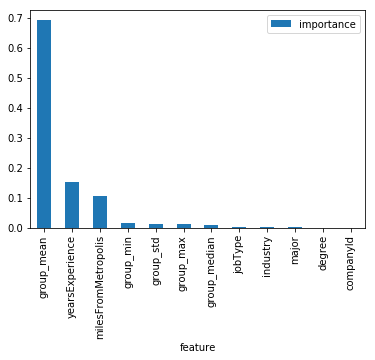

In [11]:
models.print_summary()